In [1]:
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
import matplotlib.pyplot as plt
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env.dummy_vec_env import DummyVecEnv
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize, SubprocVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_checker import check_env
import gym
import numpy as np
import time
from stable_baselines3.common.callbacks import EvalCallback
import env_test1
env = env_test1.DroneEnv()
check_env(env)
env = DummyVecEnv([lambda: env])

### 训练模型

In [2]:

#vec_env = VecNormalize(env, norm_obs=True, norm_reward=True,clip_obs=1)


# Evaluation callback
callbacks = []
eval_callback = EvalCallback(
    env,
    callback_on_new_best=None,
    n_eval_episodes=8,
    best_model_save_path=".",
    log_path=".",
    eval_freq=4000,
)

callbacks.append(eval_callback)
kwargs = {}
kwargs["callback"] = callbacks

log_name = "ppo_run_" + str(time.time())


In [3]:
model = PPO("MlpPolicy", env, verbose=1, tensorboard_log="./tensorboard/",device="cuda")
model.learn(
    total_timesteps=400000,
    tb_log_name=log_name,
    **kwargs
)
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=50)
print(f"Before training: mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")
model.save("last_model")

Using cuda device
Logging to ./tensorboard/ppo_run_1715756228.2208412_1
-----------------------------
| time/              |      |
|    fps             | 445  |
|    iterations      | 1    |
|    time_elapsed    | 4    |
|    total_timesteps | 2048 |
-----------------------------


C:\ProgramData\anaconda3\envs\UAV\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4000, episode_reward=-18106.38 +/- 0.00
Episode length: 501.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 501          |
|    mean_reward          | -1.81e+04    |
| time/                   |              |
|    total_timesteps      | 4000         |
| train/                  |              |
|    approx_kl            | 0.0015927805 |
|    clip_fraction        | 0.00181      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.41        |
|    explained_variance   | 6.74e-06     |
|    learning_rate        | 0.0003       |
|    loss                 | 5.4e+05      |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00249     |
|    std                  | 0.993        |
|    value_loss           | 1.14e+06     |
------------------------------------------
New best mean reward!
-----------------------------
| time/              |      |
|    fps  

In [3]:
#del model
model = PPO("MlpPolicy", env, verbose=1, tensorboard_log="./tensorboard/",device="cuda")
model.set_parameters("best_model")
model.learn(
    total_timesteps=400000,
    tb_log_name=log_name,
    **kwargs
)

Using cuda device
Logging to ./tensorboard/ppo_run_1715759030.109828_1
-----------------------------
| time/              |      |
|    fps             | 532  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------


C:\ProgramData\anaconda3\envs\UAV\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4000, episode_reward=-4085.45 +/- 3161.50
Episode length: 367.75 +/- 38.94
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 368          |
|    mean_reward          | -4.09e+03    |
| time/                   |              |
|    total_timesteps      | 4000         |
| train/                  |              |
|    approx_kl            | 0.0018891745 |
|    clip_fraction        | 0.00874      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.915       |
|    explained_variance   | 0.0534       |
|    learning_rate        | 0.0003       |
|    loss                 | 6.26e+04     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00131     |
|    std                  | 0.606        |
|    value_loss           | 2.34e+05     |
------------------------------------------
New best mean reward!
-----------------------------
| time/              |      |
|    fp

### 绘图检验

In [4]:
model.save("last_model")

KeyboardInterrupt: 

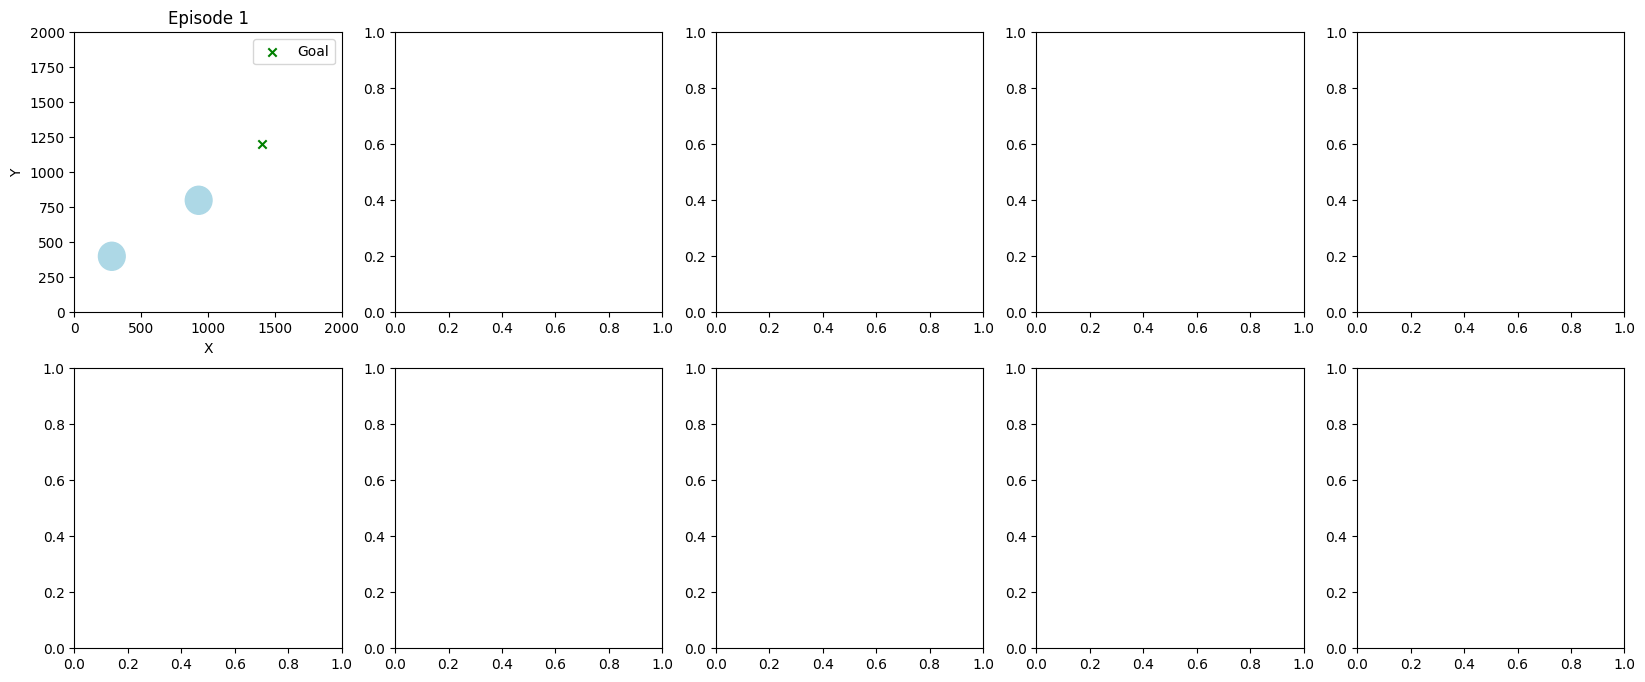

In [3]:
import matplotlib.pyplot as plt

# 创建一个包含10个子图的窗口
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
axs = axs.ravel()  # 将二维数组展平，方便通过索引访问每个子图

env = env_test1.DroneEnv()
for i in range(10):
    # 重置环境
    state, info = env.reset()
    trajectory_x = [env.xy_p[0]]  # 存储无人机路径的x坐标
    trajectory_y = [env.xy_p[1]]  # 存储无人机路径的y坐标
    trajectory_ex = [env.xy_e[0]]  # 存储无人机路径的x坐标
    trajectory_ey = [env.xy_e[1]]  # 存储无人机路径的y坐标
    axs[i].set_xlim(env.space1.low[0], env.space1.high[0])
    axs[i].set_ylim(env.space1.low[1], env.space1.high[1])
    axs[i].set_xlabel('X')
    axs[i].set_ylabel('Y')
    axs[i].legend()
    axs[i].set_title(f'Episode {i+1}')
    # 通过预训练模型控制无人机执行任务并绘制路径
    model = PPO.load("last_model") 
    done = False
    total_reward = 0
    count = 0
    while not done:
       
        count += 1
        action, _states = model.predict(state, deterministic=True)
        next_state, reward, done, t, info = env.step(action)
        #if reward < -10:
            #print(state, action, reward)
        if count > 500:
            done = True
        total_reward += reward
        state = next_state
        trajectory_x.append(env.xy_p[0])  # 更新无人机路径的x坐标
        trajectory_y.append(env.xy_p[1])  # 更新无人机路径的y坐标
        trajectory_ex.append(env.xy_e[0])  # 更新无人机路径的x坐标
        trajectory_ey.append(env.xy_e[1])  # 更新无人机路径的y坐标

    # 绘制无人机路径
    axs[i].plot(trajectory_x, trajectory_y, color='red', linewidth=0.5)
    axs[i].plot(trajectory_ex, trajectory_ey, color='red', linewidth=0.5)

    # 打印每个episode的总奖励
    print(f'Episode {i+1} total reward:', total_reward)

# 显示子图窗口
plt.tight_layout()
plt.show()


In [ ]:
# 假设env.obstacles返回当前时间步的障碍物位置列表

plt.ion()  # 开启交互模式，允许动态更新图形
fig, ax = plt.subplots()
circles = []  # 存储障碍物的圆形对象

def draw_obstacles(obstacles):
    # 清除之前的障碍物绘制
    for circle in circles:
        ax.add_patch(circle)
    plt.draw()

    # 重新绘制障碍物
    for k in obstacles:
        circle = plt.Circle(k, env.r_obstacles, color='lightblue', fill=True)
        ax.add_patch(circle)
        circles.append(circle)
    plt.xlim(env.space1.low[0], env.space1.high[0])
    plt.ylim(env.space1.low[1], env.space1.high[1])
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.title('Drone Environment')

    plt.draw()  # 更新图形

env = env_test1.DroneEnv()
model = PPO.load("last_model") 
done = False
r = 0
state, info = env.reset()

# 绘制初始障碍物
draw_obstacles(env.obstacles)

count = 0
while not done:
    count += 1
    print(count)

    action, _states = model.predict(state, deterministic=True)
    next_state, reward, done, t, info = env.step(action)
    r += reward
    state = next_state

    # 动态更新障碍物的可视化
    draw_obstacles(env.obstacles)

    if count > 500:
        done = True

plt.ioff()  # 关闭交互模式
plt.show()  # 显示最终的绘图结果

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1
2
3
4


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


5
6
7


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


8
9
10


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


11
12


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


13
14


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


15
16


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


17


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


18


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


19


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


20


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


21


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


22


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


23
24


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


25


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


26


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


27


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


28


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


29


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


30


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


31


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


32


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


33


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


34


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


35


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


36


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


37


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


38


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


39


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


40


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


41


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


42


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


43


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


44


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


45


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


46


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


47


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


48


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


49


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


50


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


51


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


52


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


53


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


54


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


55


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


56


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


57


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


58


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


59


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


60


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


61


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


62


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


63


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


64


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


65


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


66


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


67


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


68


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


69


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


70


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


71


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


72


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


73


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


74


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


75


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


76


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


77


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


78


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


79


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


80


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


81


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


82


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


83


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


84


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


85


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


86


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


87


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


88


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


89


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


182


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


183


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


184


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


185


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


KeyboardInterrupt: 